# Test MLP Policy  with Engine Failure

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Mars3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Mars3DOF/Engine_failure


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
queue fixed
Flat Constraint


<IPython.core.display.Javascript object>


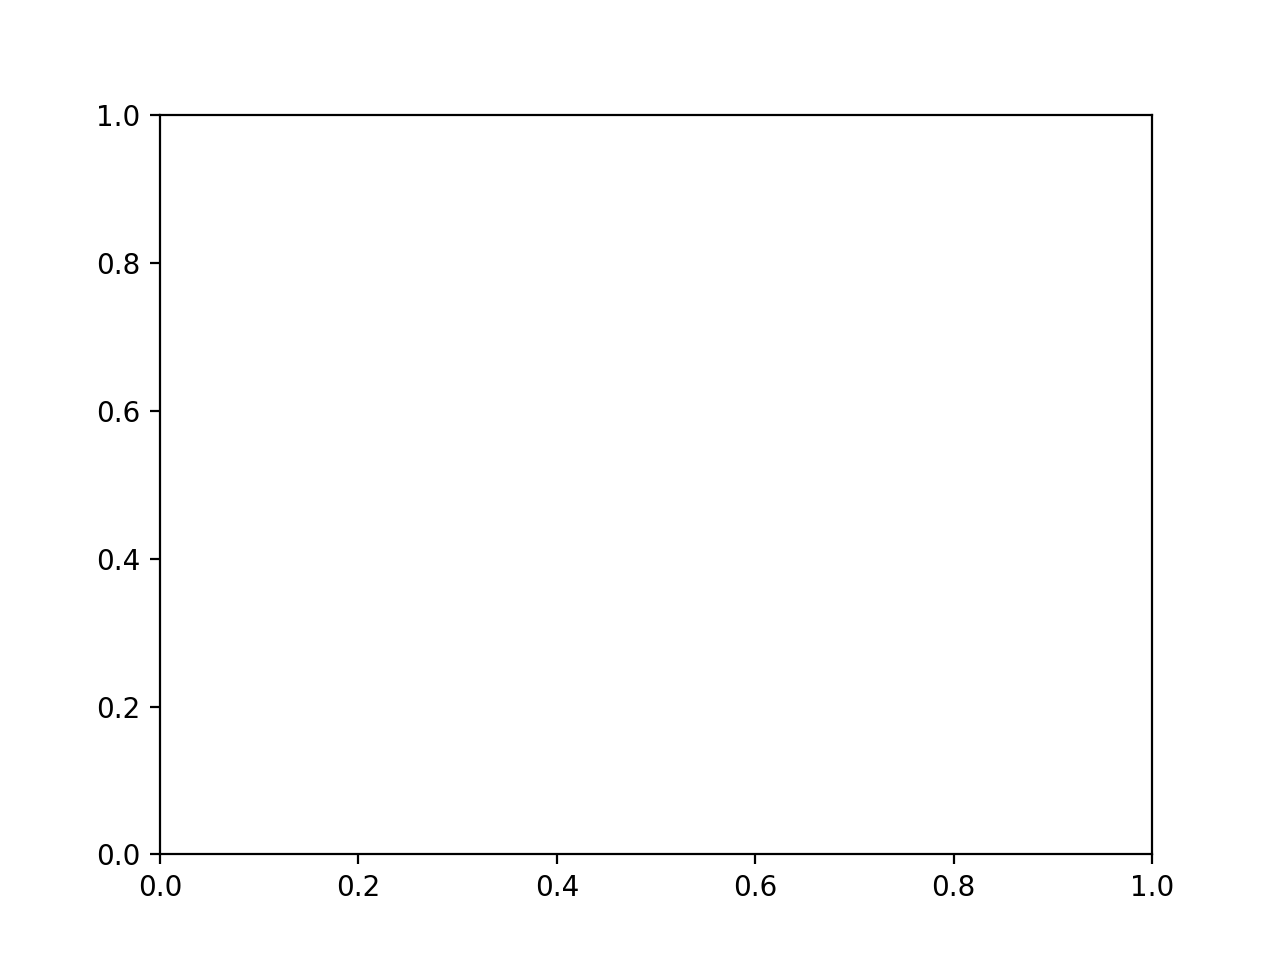

<IPython.core.display.Javascript object>


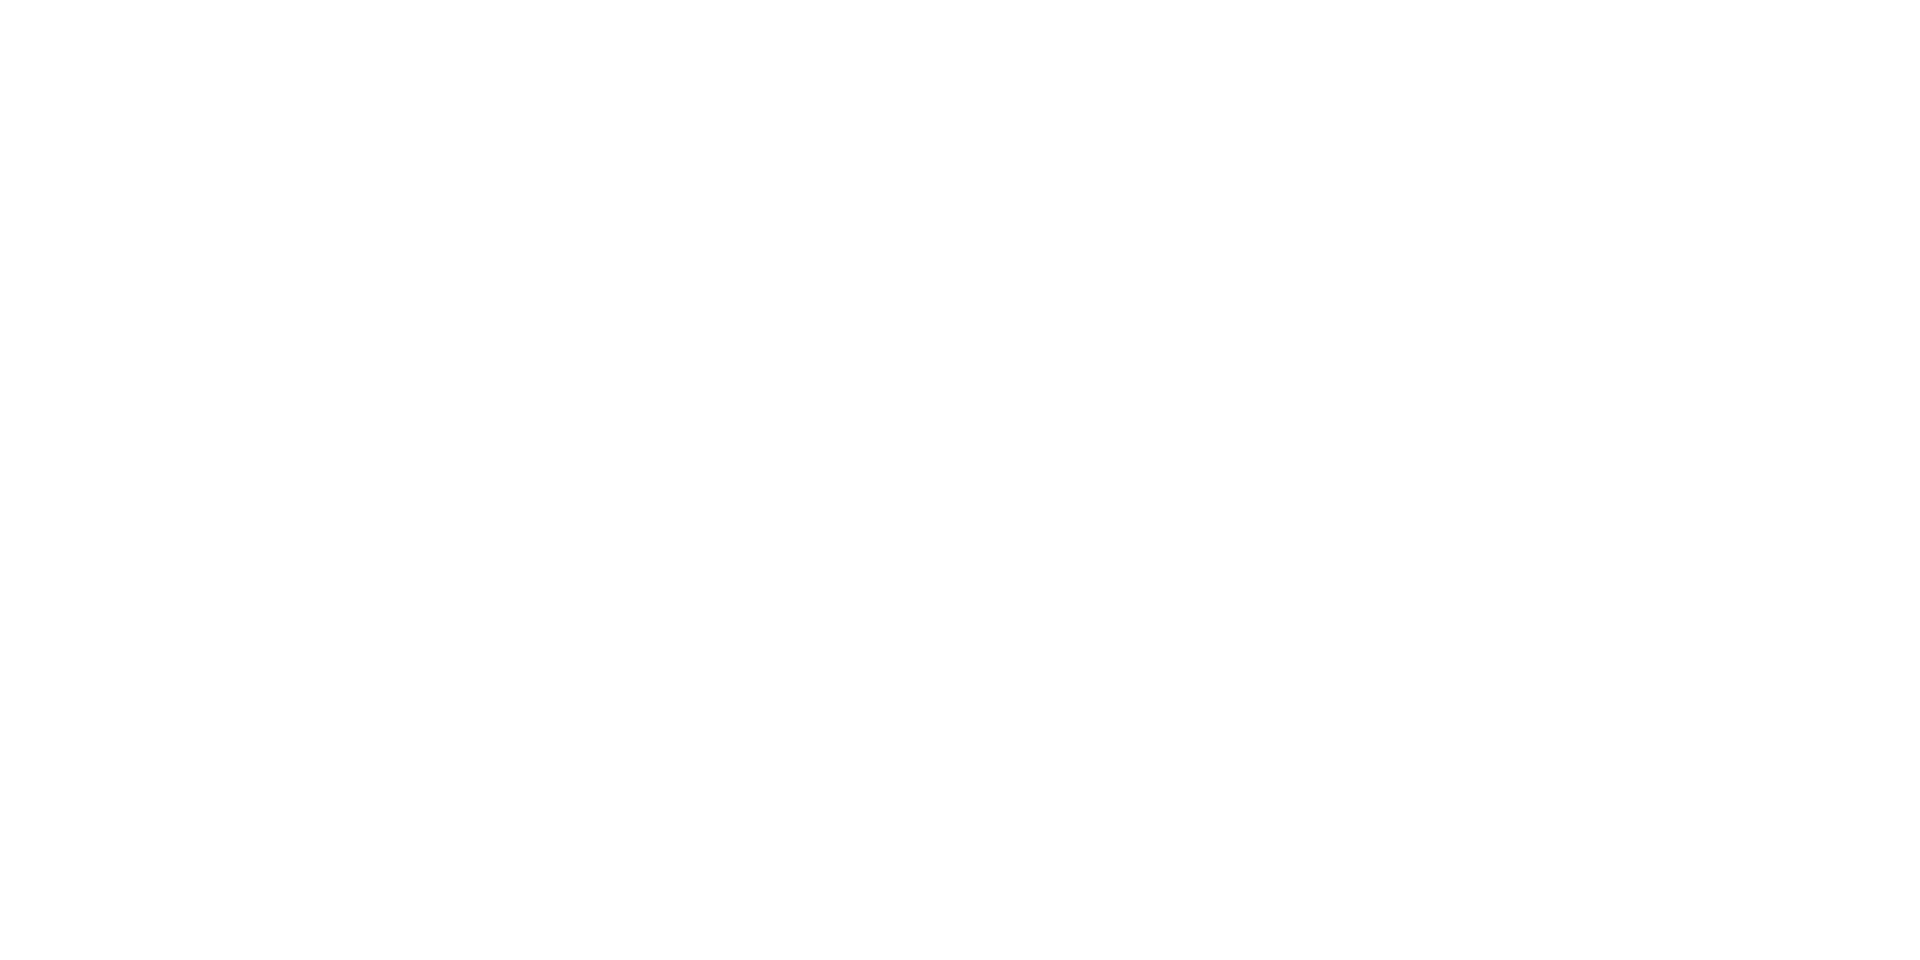

<IPython.core.display.Javascript object>


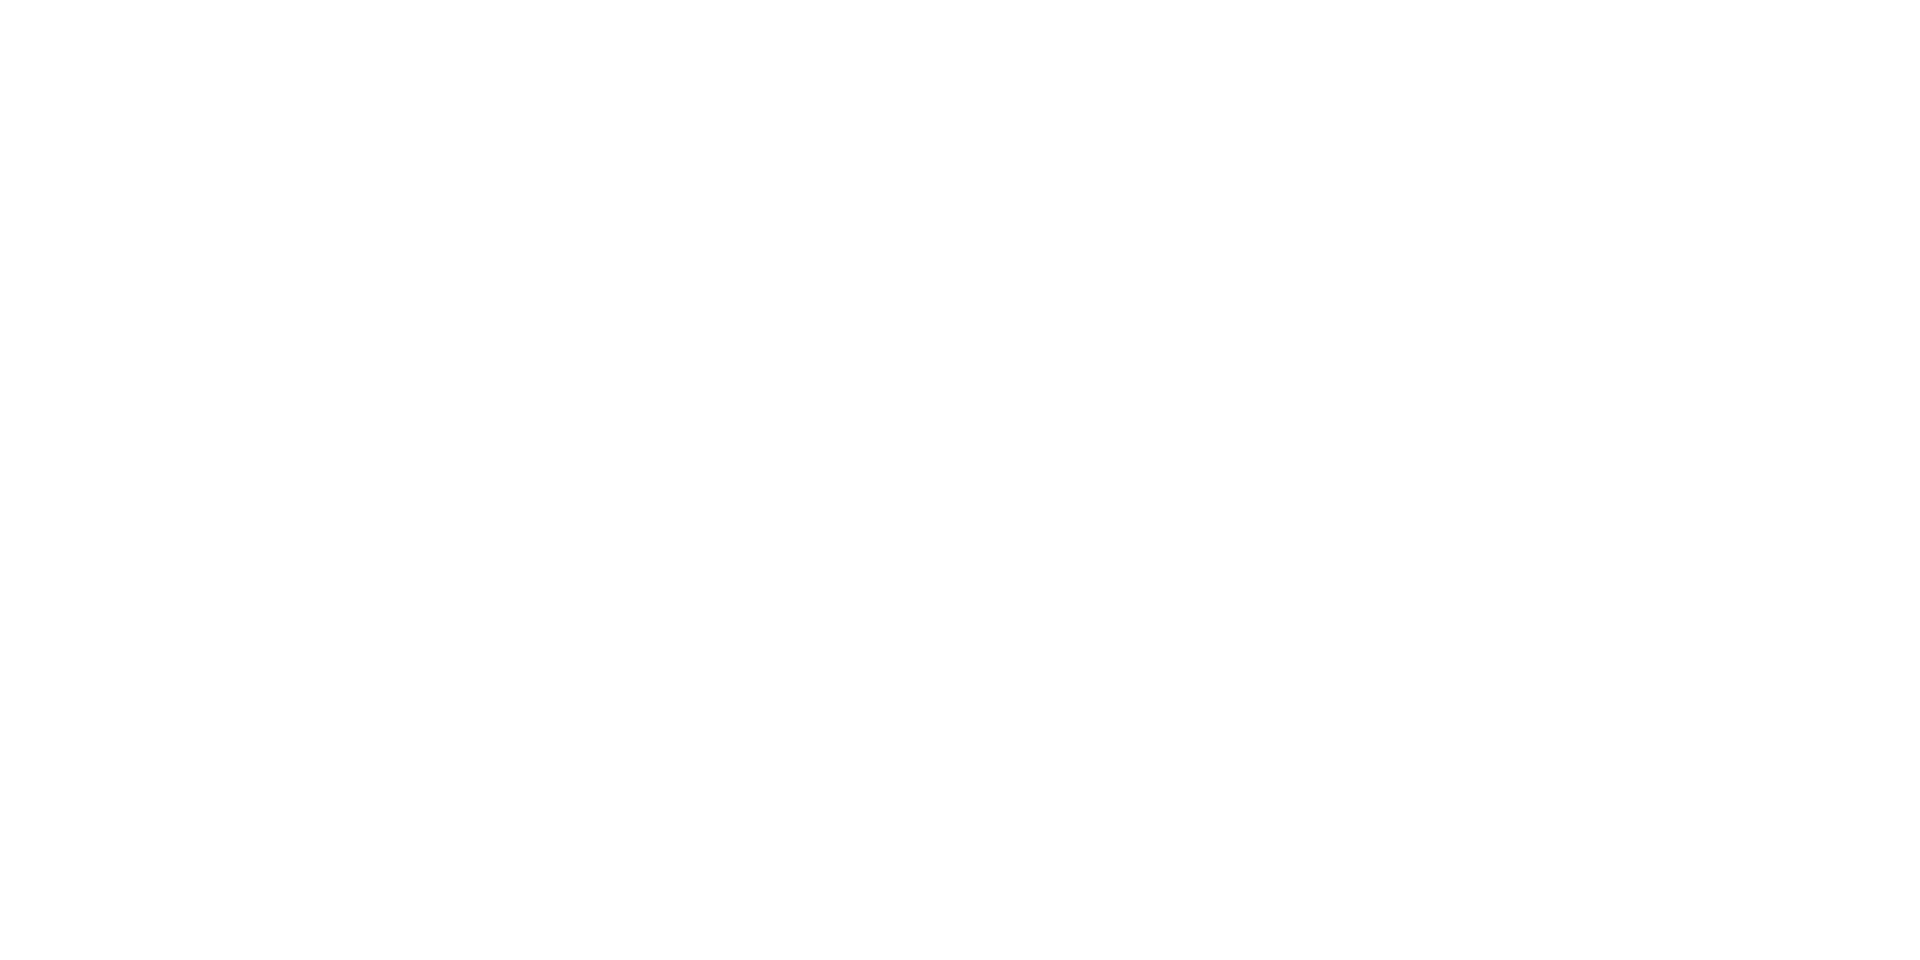

<IPython.core.display.Javascript object>


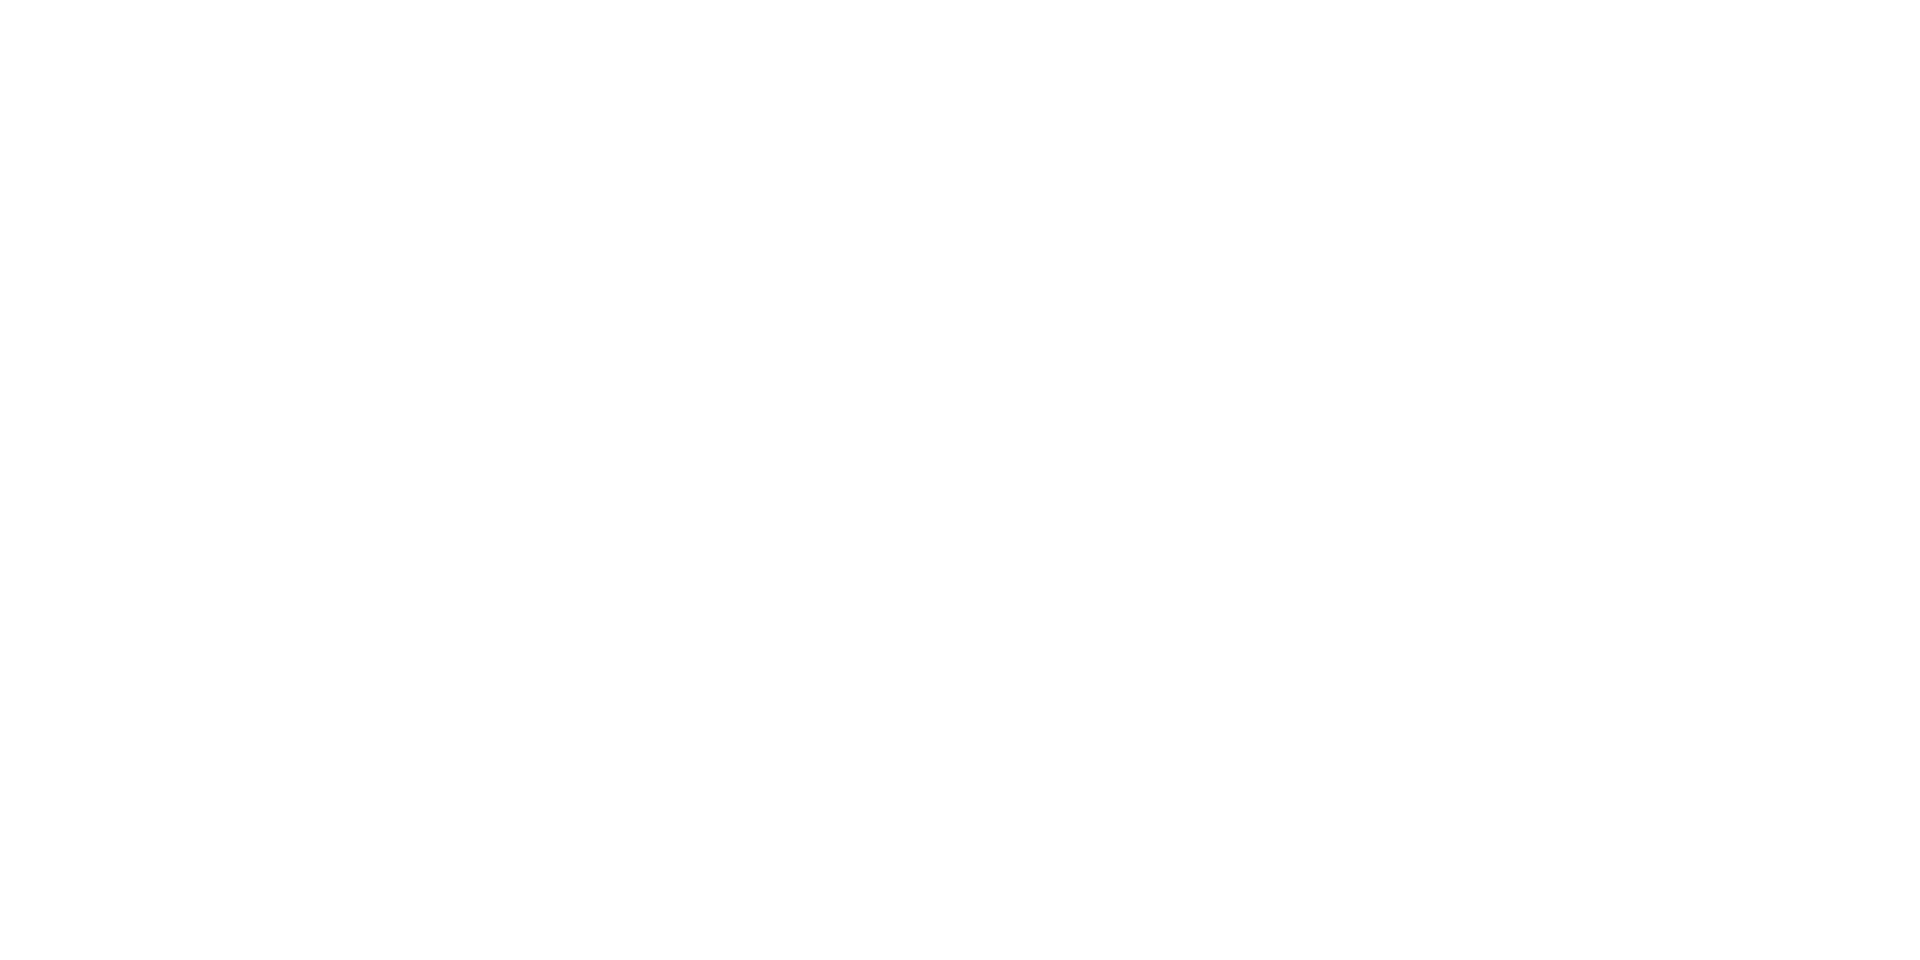

<IPython.core.display.Javascript object>


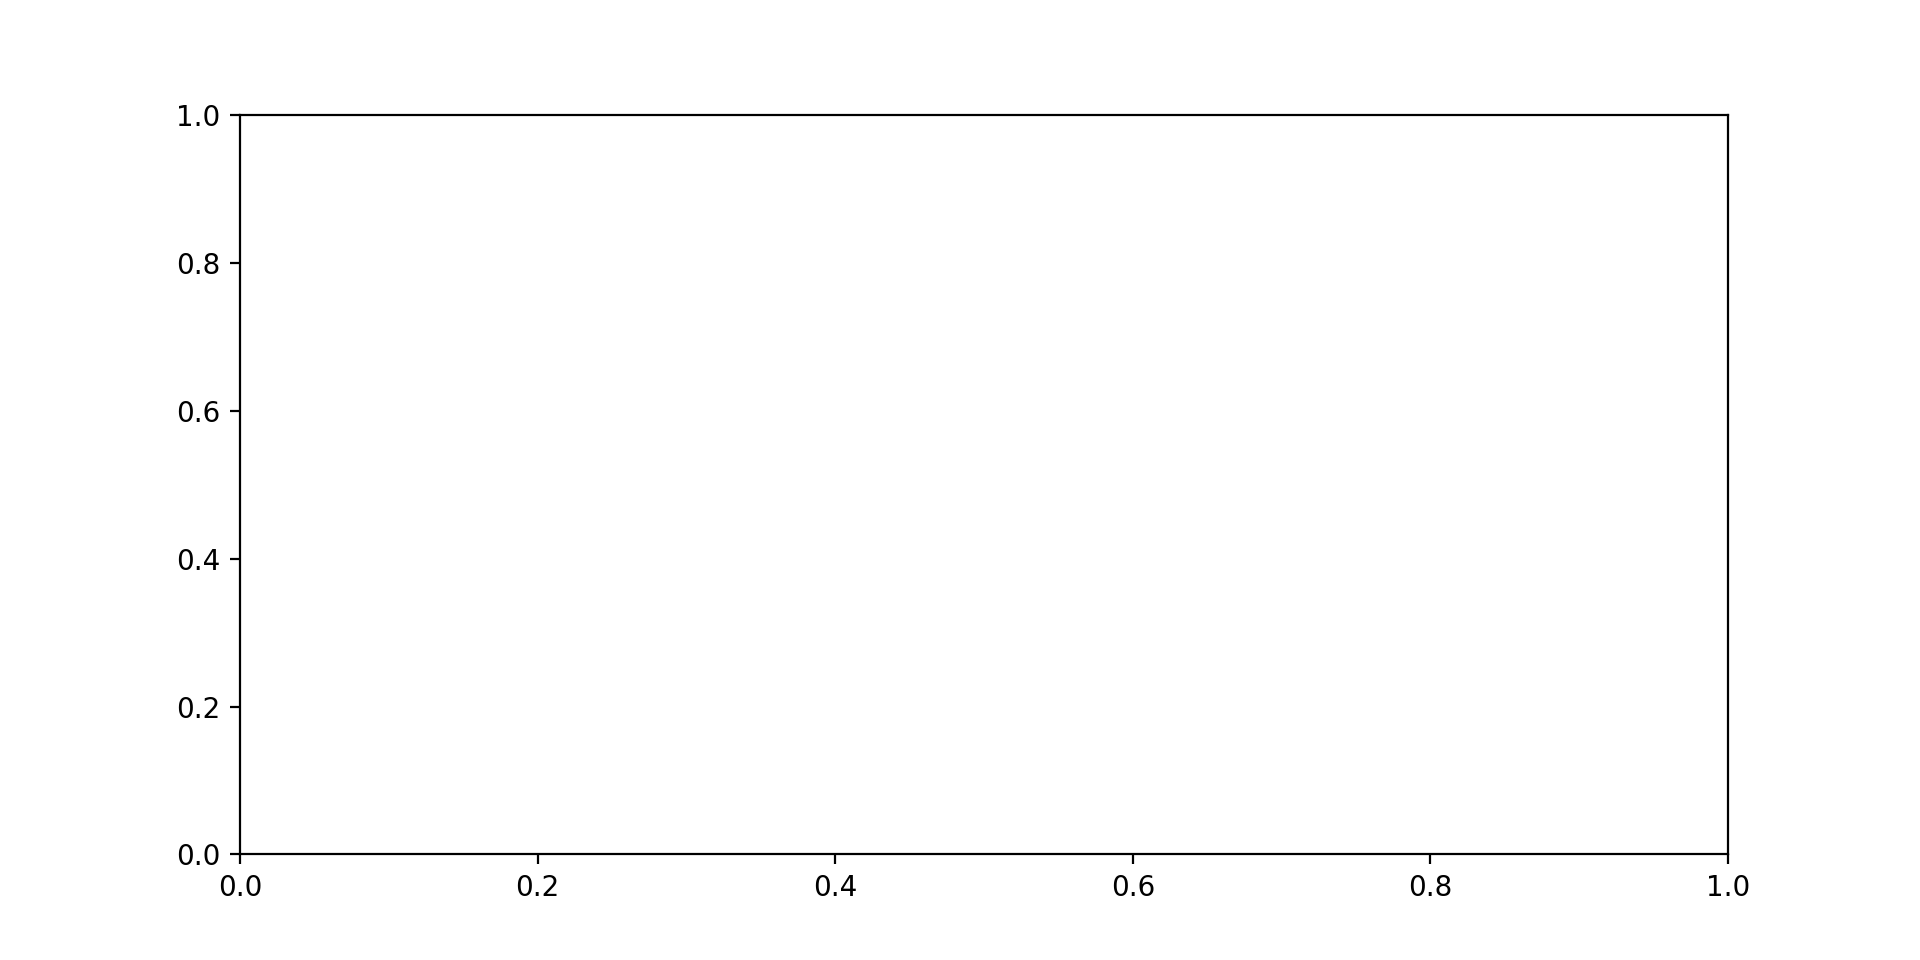

Lander Env
Landing_icgen:
    nominal_g                   :  -3.7114
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
    adjust_apf_v0               :  True
Policy with vectorized sample
	xn_init: layer  Linear(in_features=5, out_features=50, bias=True)
	xn_init: layer  GRUCell(50, 38)
	xn_init: layer  Linear(in_features=38, out_features=30, bias=True)
	xn_init: layer  Linear(in_features=30, out_features=3, bias=True)
Policy: recurrent steps > 1, disabling shuffle
[[-1.]
 [ 0.]
 [ 1.]]
	Test Mode:          False
	Clip Param:         0.1
	Shuffle :           False
	Max Grad Norm:      30
	Recurrent Steps:    60
	Rollout Limit:      1
Value Funtion
	xn_init: layer  Linear(in_features=5, out_features=50, bias=True)
	xn_init: layer  GRUCell(50, 15)
	xn_init: layer  Linear(in_features=15, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, 

In [4]:
from env_killengine_test import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen2 import Landing_icgen
import rl_utils

from arch_policy_vf import Arch


from policy import Policy
from value_function import Value_function

import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model()
lander_model = Lander_model(apf_tau1=20,apf_tau2=100,apf_vf1=-2,apf_vf2=-1,apf_v0=70,apf_atarg=15.)
lander_model.get_state_agent = lander_model.get_state_agent5
lander_model.max_thrust = 24000
lander_model.min_thrust = 4000
obs_dim = 5
act_dim = 3
recurrent_steps = 60

reward_object = Reward()

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          kill_lateral_scale=3.0,
          kill_vertical_scale=1.5,
          tf_limit=100.0,print_every=10,
          p_kill=0.5)

env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.05,0.05),
                           adjust_apf_v0=True,
                          downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70))
env.ic_gen.show()

arch = Arch()

policy = Policy(policy_nets.GRU(obs_dim, act_dim, recurrent_steps=recurrent_steps), shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30,
                init_func=rl_utils.xn_init)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
fname = "recurrent_policy-rkill-60step"
policy.load_params(fname)
value_function.load_params(fname)


# Test Policy 

In [5]:
policy.test_mode=True
  
env.test_policy_batch(agent,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10057.08 |3114.69 |4000.00 |24000.00 |    41
glideslope | 5.575 |17.430 | 0.428 |1273.388 |    56
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.004 |   0.064 |   0.858 |   1.136
norm_rf  |     0.3 |     0.2 |     0.0 |     0.9
position |     0.1    -0.0    -0.0 |     0.3     0.2     0.0 |    -0.6    -0.5    -0.1 |     0.9     0.5    -0.0
velocity |   0.071   0.001  -1.000 |   0.039   0.043   0.063 |  -0.004  -0.072  -1.136 |   0.189   0.126  -0.854
fuel     |294.55 | 15.47 |266.40 |344.98
glideslope | 26.47 | 24.02 |  9.21 |225.74
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |10026.62 |3235.44 |4000.00 |24000.00 |   134
glideslope | 5.671 |16.832 | 0.428 |1273.388 |    56
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.996 |   0.063 |   0.844 |   1.136
norm_rf  |     0.3 |     0.2 |     0.0 |     0.9
position |  

i :  1400
Cumulative Stats (mean,std,max,argmax)
thrust   |10026.97 |3200.80 |4000.00 |24000.00 |   289
glideslope | 5.853 |33.112 | 0.428 |17488.418 |   945
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.063 |   0.804 |   1.147
norm_rf  |     0.3 |     0.2 |     0.0 |     1.1
position |     0.1    -0.0    -0.0 |     0.3     0.2     0.0 |    -0.8    -0.8    -0.1 |     0.9     0.8    -0.0
velocity |   0.071  -0.000  -0.998 |   0.039   0.043   0.062 |  -0.009  -0.088  -1.141 |   0.198   0.133  -0.799
fuel     |295.03 | 15.33 |256.27 |345.24
glideslope | 27.18 | 28.45 |  8.43 |730.31
i :  1500
Cumulative Stats (mean,std,max,argmax)
thrust   |10028.40 |3203.96 |4000.00 |24000.00 |   289
glideslope | 5.839 |32.289 | 0.428 |17488.418 |   945
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.063 |   0.804 |   1.147
norm_rf  |     0.3 |     0.2 |     0.0 |     1.1
position

i :  2700
Cumulative Stats (mean,std,max,argmax)
thrust   |10026.49 |3214.98 |4000.00 |24000.00 |  2369
glideslope | 5.904 |29.914 | 0.428 |17488.418 |   945
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.002 |   0.062 |   0.804 |   1.147
norm_rf  |     0.3 |     0.2 |     0.0 |     1.1
position |     0.1    -0.0    -0.0 |     0.3     0.2     0.0 |    -0.8    -0.9    -0.1 |     1.0     0.9    -0.0
velocity |   0.071  -0.001  -0.998 |   0.038   0.042   0.061 |  -0.011  -0.088  -1.142 |   0.198   0.133  -0.799
fuel     |295.04 | 15.56 |256.27 |372.77
glideslope | 27.76 | 28.47 |  8.43 |730.31
i :  2800
Cumulative Stats (mean,std,max,argmax)
thrust   |10026.07 |3210.38 |4000.00 |24000.00 |  2369
glideslope | 5.921 |30.130 | 0.428 |17488.418 |   945
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.062 |   0.804 |   1.147
norm_rf  |     0.3 |     0.2 |     0.0 |     1.1
position

i :  4000
Cumulative Stats (mean,std,max,argmax)
thrust   |10033.90 |3222.79 |4000.00 |24000.00 |  2369
glideslope | 5.922 |40.505 | 0.428 |32632.362 |  3210
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.002 |   0.062 |   0.804 |   1.157
norm_rf  |     0.3 |     0.2 |     0.0 |     1.1
position |     0.1    -0.0    -0.0 |     0.3     0.2     0.0 |    -0.8    -0.9    -0.1 |     1.0     0.9    -0.0
velocity |   0.071  -0.001  -0.998 |   0.038   0.042   0.061 |  -0.012  -0.091  -1.153 |   0.201   0.135  -0.799
fuel     |294.89 | 15.45 |256.27 |372.77
glideslope | 27.81 | 29.73 |  8.26 |730.31
i :  4100
Cumulative Stats (mean,std,max,argmax)
thrust   |10036.21 |3222.29 |4000.00 |24000.00 |  2369
glideslope | 5.918 |40.108 | 0.428 |32632.362 |  3210
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.062 |   0.804 |   1.157
norm_rf  |     0.3 |     0.2 |     0.0 |     1.2
position

i :  5300
Cumulative Stats (mean,std,max,argmax)
thrust   |10042.61 |3228.06 |4000.00 |24000.00 |  2369
glideslope | 5.891 |37.998 | 0.428 |32632.362 |  3210
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.062 |   0.804 |   1.167
norm_rf  |     0.3 |     0.2 |     0.0 |     1.5
position |     0.1    -0.0    -0.0 |     0.3     0.2     0.0 |    -1.2    -0.9    -0.1 |     1.5     0.9    -0.0
velocity |   0.071  -0.000  -0.999 |   0.038   0.043   0.061 |  -0.017  -0.091  -1.163 |   0.201   0.135  -0.799
fuel     |295.15 | 15.59 |256.27 |372.77
glideslope | 27.58 | 28.36 |  8.26 |730.31
i :  5400
Cumulative Stats (mean,std,max,argmax)
thrust   |10043.76 |3229.63 |4000.00 |24000.00 |  2369
glideslope | 5.918 |37.782 | 0.428 |32632.362 |  3210
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.062 |   0.804 |   1.167
norm_rf  |     0.3 |     0.2 |     0.0 |     1.5
position

i :  6600
Cumulative Stats (mean,std,max,argmax)
thrust   |10038.36 |3227.74 |4000.00 |24000.00 |  5972
glideslope | 5.885 |35.317 | 0.428 |32632.362 |  3210
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.062 |   0.804 |   1.167
norm_rf  |     0.3 |     0.2 |     0.0 |     1.5
position |     0.1    -0.0    -0.0 |     0.3     0.2     0.0 |    -1.2    -0.9    -0.1 |     1.5     0.9    -0.0
velocity |   0.071  -0.000  -0.999 |   0.039   0.043   0.061 |  -0.017  -0.091  -1.163 |   0.202   0.143  -0.799
fuel     |295.21 | 15.61 |252.28 |372.77
glideslope | 27.57 | 28.73 |  8.26 |730.31
i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |10038.41 |3230.09 |4000.00 |24000.00 |  5972
glideslope | 5.886 |35.186 | 0.428 |32632.362 |  3210
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.062 |   0.804 |   1.167
norm_rf  |     0.3 |     0.2 |     0.0 |     1.5
position

i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |10038.96 |3232.46 |4000.00 |24000.00 |  5972
glideslope | 5.909 |33.745 | 0.023 |32632.362 |  3210
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.061 |   0.804 |   1.167
norm_rf  |     0.3 |     0.2 |     0.0 |     7.6
position |     0.1    -0.0    -0.0 |     0.3     0.2     0.0 |    -6.4    -0.9    -0.1 |     1.5     4.1    -0.0
velocity |   0.071  -0.001  -0.999 |   0.039   0.043   0.060 |  -0.017  -0.091  -1.163 |   0.202   0.143  -0.799
fuel     |295.26 | 15.71 |252.28 |372.77
glideslope | 27.87 | 31.09 |  8.26 |1020.06
i :  8000
Cumulative Stats (mean,std,max,argmax)
thrust   |10038.22 |3229.92 |4000.00 |24000.00 |  5972
glideslope | 5.914 |33.607 | 0.023 |32632.362 |  3210
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.061 |   0.804 |   1.167
norm_rf  |     0.3 |     0.2 |     0.0 |     7.6
positio

i :  9200
Cumulative Stats (mean,std,max,argmax)
thrust   |10042.99 |3230.47 |4000.00 |24000.00 |  5972
glideslope | 5.908 |32.163 | 0.023 |32632.362 |  3210
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.061 |   0.804 |   1.167
norm_rf  |     0.3 |     0.2 |     0.0 |     7.6
position |     0.1    -0.0    -0.0 |     0.3     0.2     0.0 |    -6.4    -0.9    -0.1 |     1.5     4.1    -0.0
velocity |   0.071  -0.000  -0.999 |   0.039   0.043   0.060 |  -0.017  -0.091  -1.163 |   0.202   0.143  -0.799
fuel     |295.16 | 15.75 |252.28 |372.77
glideslope | 27.88 | 33.97 |  7.72 |1365.82
i :  9300
Cumulative Stats (mean,std,max,argmax)
thrust   |10043.12 |3231.04 |4000.00 |24000.00 |  5972
glideslope | 5.905 |32.086 | 0.023 |32632.362 |  3210
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   1.003 |   0.061 |   0.804 |   1.167
norm_rf  |     0.3 |     0.2 |     0.0 |     7.6
positio

<IPython.core.display.Javascript object>


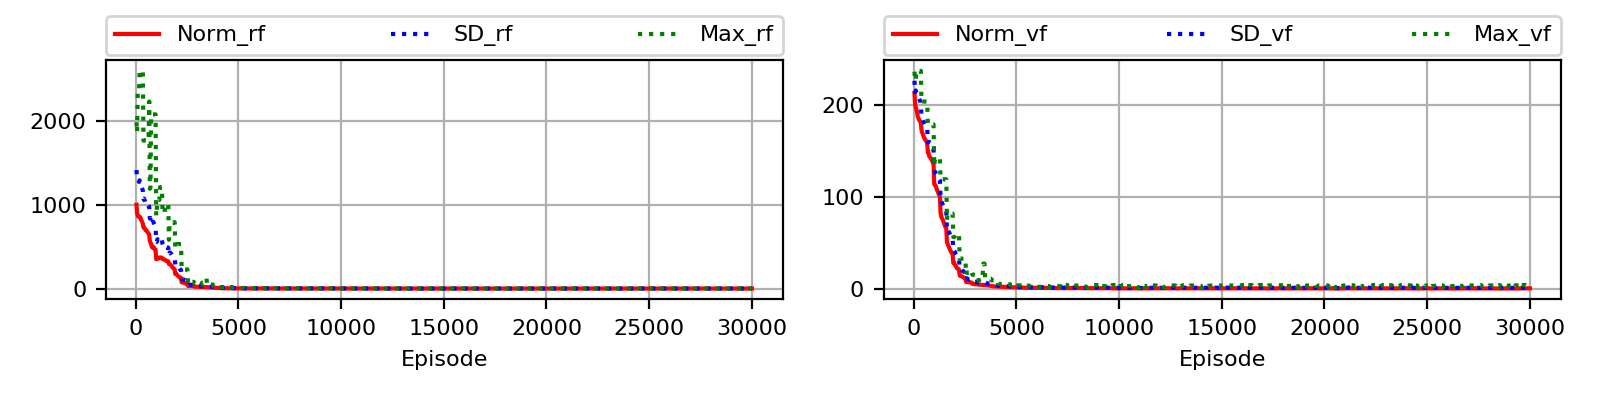

In [16]:
history = np.load(fname + "_history.npy").item()
envu.plot_rf_vf(history)